In [1]:
import os
from scipy.io import loadmat
from sklearn.linear_model import Ridge
import numpy as np

In [14]:
from scipy.io import loadmat
from sklearn.linear_model import Ridge
import numpy as np

# Load voxel beta data
mat_path = '/nfs/tpolk/mind/freesurfer/func/pmindy101/auditory/RightHemUnsm12conds.mat'
beta_data = loadmat(mat_path)
voxel_betas = np.hstack([beta_data[key] for key in sorted(beta_data) if 'cond' in key])  # shape (17995, 12)

# Load and prepare activation matrix for conv5_W
layer_file_path = '/home/tpolklabuser/Desktop/Violet/DNN/ML_RR/DNN_Activation/conv5_W_average_activation_matrix.csv'
activation_matrix = np.loadtxt(layer_file_path, delimiter=',', skiprows=1).T  # Transpose to shape (12, num_units)

# Check the shape of the activation matrix to ensure it matches (6, num_units)
print("Activation matrix shape:", activation_matrix.shape)

# Initialize Ridge Regression model
ridge_alpha = 1.0
ridge_model = Ridge(alpha=ridge_alpha)

# Initialize array to store weights for each voxel
num_voxels = voxel_betas.shape[0]
num_units = activation_matrix.shape[1]
weights = np.zeros((num_voxels, num_units))  # Each voxel has a weight vector across all units in conv5_W

# Loop over each voxel and fit ridge regression
for voxel_idx in range(num_voxels):
    # Get the beta values for this voxel across conditions
    voxel_response = voxel_betas[voxel_idx, :].reshape(1, -1)  # shape (1, 6)

    # Fit ridge regression model
    ridge_model.fit(activation_matrix, voxel_response.ravel())

    # Store the weights (coefficients) for this voxel
    weights[voxel_idx, :] = ridge_model.coef_

# weights array now has shape (17995, num_units)
# Each row corresponds to a voxel, and each column is a weight for a specific unit in conv5_W
print("Weights shape:", weights.shape)


Activation matrix shape: (12, 61952)
Weights shape: (17995, 61952)


In [17]:
print(activation_matrix.shape)


(12, 61952)


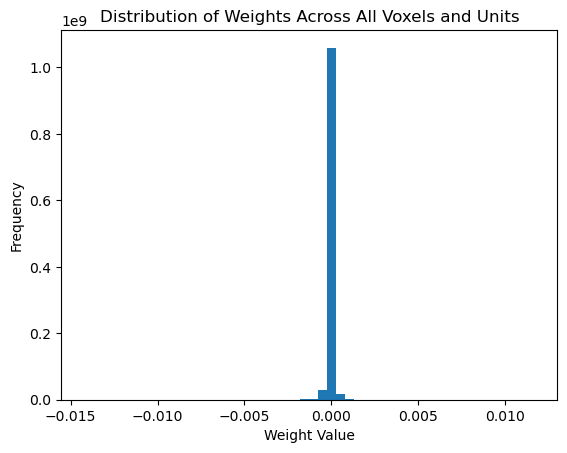

In [15]:
import matplotlib.pyplot as plt

plt.hist(weights.flatten(), bins=50)
plt.title("Distribution of Weights Across All Voxels and Units")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()

In [20]:
from scipy.io import loadmat
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Define layers to analyze (only test conv1 and conv5_W for now)
layers = ["conv1", "conv5_W"]

# Prepare to store correlations for each layer
layer_correlations = {}

# Load voxel beta data (all 12 conditions)
mat_path = '/nfs/tpolk/mind/freesurfer/func/pmindy101/auditory/RightHemUnsm12conds.mat'
beta_data = loadmat(mat_path)
voxel_betas = np.hstack([beta_data[key] for key in sorted(beta_data) if 'cond' in key])  # shape (17995, 12)

# Run ridge regression with Leave-Two-Conditions-Out cross-validation for each layer
for layer in layers:
    print(f"Processing layer: {layer}")

    # Load layer activation matrix and transpose to shape (12, num_units)
    layer_file_path = f'/home/tpolklabuser/Desktop/Violet/DNN/ML_RR/DNN_Activation/{layer}_average_activation_matrix.csv'
    activation_matrix = np.loadtxt(layer_file_path, delimiter=',', skiprows=1).T  # shape (12, num_units)

    # Initialize ridge regression model
    ridge_alpha = 1.0
    ridge_model = Ridge(alpha=ridge_alpha)

    # Store voxel-wise correlations
    voxel_correlations = []

    # Run cross-validated ridge regression for each voxel
    for voxel_idx in range(voxel_betas.shape[0]):
        if voxel_idx % 1000 == 0:
            print(f"    Processing Voxel {voxel_idx + 1}/{voxel_betas.shape[0]}")

        voxel_response = voxel_betas[voxel_idx, :].reshape(1, -1)

        # Store correlations for each pair of test conditions
        condition_correlations = []

        # Leave-Two-Conditions-Out Cross-Validation
        for test_conds in combinations(range(voxel_response.shape[1]), 2):
            # Create training and test sets
            train_conditions = np.delete(activation_matrix, test_conds, axis=0)
            train_responses = np.delete(voxel_response, test_conds, axis=1).ravel()

            test_conditions = activation_matrix[list(test_conds), :]

            # Fit ridge regression model on training data
            ridge_model.fit(train_conditions, train_responses)

            # Predict the left-out conditions
            predictions = ridge_model.predict(test_conditions)

            # Calculate correlation between predictions and actual test conditions
            actual_responses = voxel_response[0, list(test_conds)]
            correlation, _ = pearsonr(predictions, actual_responses)
            condition_correlations.append(correlation)

        # Average correlation across condition pairs for this voxel
        voxel_correlations.append(np.mean(condition_correlations))

    # Save average correlation per layer
    layer_correlations[layer] = np.mean(voxel_correlations)
    print(f"Average correlation for layer {layer}: {layer_correlations[layer]}")

# Plot average correlations for conv1 and conv5_W
plt.figure()
plt.plot(layers, [layer_correlations[layer] for layer in layers], marker='o')
plt.title("Average Correlation of DNN Layers (conv1 and conv5_W) with Brain Voxels (Leave-Two-Conditions-Out)")
plt.xlabel("DNN Layers")
plt.ylabel("Average Correlation (Pearson's R)")
plt.show()


Processing layer: conv1
    Processing Voxel 1/17995


KeyboardInterrupt: 

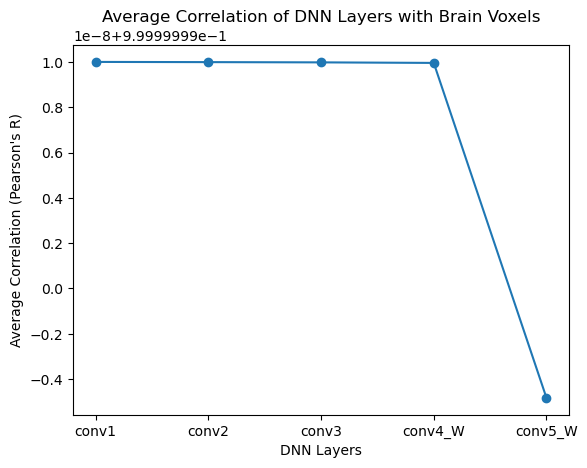

In [18]:
# to test activation in all layers versus voxels in mindy101
from scipy.io import loadmat
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# Define layers to analyze
layers = ["conv1", "conv2", "conv3", "conv4_W", "conv5_W"]

# Prepare to store correlations for each layer
layer_correlations = {}

# Load voxel beta data (all conditions)
mat_path = '/nfs/tpolk/mind/freesurfer/func/pmindy101/auditory/RightHemUnsm12conds.mat'
beta_data = loadmat(mat_path)
voxel_betas = np.hstack([beta_data[key] for key in sorted(beta_data) if 'cond' in key])  # shape (17995, 6)

# Run ridge regression for each layer
for layer in layers:
    # Load layer activation matrix and transpose to shape (6, num_units)
    layer_file_path = f'/home/tpolklabuser/Desktop/Violet/DNN/ML_RR/DNN_Activation/{layer}_average_activation_matrix.csv'
    activation_matrix = np.loadtxt(layer_file_path, delimiter=',', skiprows=1).T  # shape (12, num_units)

    # Initialize ridge regression model
    ridge_alpha = 1.0
    ridge_model = Ridge(alpha=ridge_alpha)

    # Store voxel-wise correlations
    voxel_correlations = []

    # Run ridge regression for each voxel
    for voxel_idx in range(voxel_betas.shape[0]):
        voxel_response = voxel_betas[voxel_idx, :].reshape(1, -1)

        # Fit ridge regression
        ridge_model.fit(activation_matrix, voxel_response.ravel())

        # Predict voxel responses
        predictions = ridge_model.predict(activation_matrix)

        # Calculate correlation between predictions and actual voxel responses across conditions
        correlation, _ = pearsonr(predictions, voxel_response.ravel())
        voxel_correlations.append(correlation)

    # Save average correlation per layer
    layer_correlations[layer] = np.mean(voxel_correlations)

# Plot average correlations across layers
plt.figure()
plt.plot(layers, [layer_correlations[layer] for layer in layers], marker='o')
plt.title("Average Correlation of DNN Layers with Brain Voxels")
plt.xlabel("DNN Layers")
plt.ylabel("Average Correlation (Pearson's R)")
plt.show()


In [13]:
import os
from scipy.io import loadmat
from sklearn.linear_model import Ridge
import numpy as np
from scipy.stats import pearsonr

# Define directories and parameters
base_dir = '/nfs/tpolk/mind/freesurfer/func/'
activations_dir = '/home/tpolklabuser/Desktop/Violet/DNN/ML_RR/DNN_Activation'
ridge_alpha = 1.0  # Ridge regression parameter

# List of test subjects and layers of interest
test_subjects = ["pmindy101", "pmindy102", "pmindy103", "pmindy104", "pmindy106", "pmindy110", "pmindy111", "pmindy113","pmindy117","pmindy119"]
layers = ["conv1", "conv2", "conv3", "conv4_G", "conv4_W", "conv5_W", "conv5_G"]

# Dictionary to store layer activations
layer_activations = {}

# Load each layer's activation matrix
for layer in layers:
    layer_file_path = os.path.join(activations_dir, f"{layer}_average_activation_matrix.csv")
    if os.path.exists(layer_file_path):
        layer_activations[layer] = np.loadtxt(layer_file_path, delimiter=',', skiprows=1)
    else:
        print(f"Activation file not found for layer {layer}")
        layer_activations[layer] = None

# Dictionary to store results
correlations = {layer: [] for layer in layers}

# Perform ridge regression for each subject and layer
for subject_id in test_subjects:
    # Load voxel beta values
    mat_path = os.path.join(base_dir, subject_id, 'auditory', 'RightHemUnsm12conds.mat')
    beta_data = loadmat(mat_path)
    
    # Extract and concatenate data across conditions
    voxel_betas = np.concatenate([beta_data[key] for key in beta_data if 'cond' in key], axis=1)
    
    # Get the subject index (assuming all subjects are aligned across layers in activation files)
    subject_index = int(subject_id[-3:]) - 101  # Adjust based on your indexing method

    for layer in layers:
        # Ensure layer data is loaded
        if layer_activations[layer] is None:
            continue

        # Get activation data for the specific subject
        activation_matrix = layer_activations[layer][:, subject_index]

        # Reshape if necessary to match the ridge regression format (if single column, add a new axis)
        if activation_matrix.ndim == 1:
            activation_matrix = activation_matrix[:, np.newaxis]

        # Ridge regression model
        ridge_model = Ridge(alpha=ridge_alpha)
        ridge_model.fit(activation_matrix, voxel_betas)
        predictions = ridge_model.predict(activation_matrix)

        # Calculate correlation per voxel between predicted and actual values
        layer_correlations = [pearsonr(predictions[:, i], voxel_betas[:, i])[0] for i in range(voxel_betas.shape[1])]
        correlations[layer].append(layer_correlations)

# Calculate average correlations across subjects for each layer
average_correlations = {layer: np.mean(correlations[layer], axis=0) for layer in layers if correlations[layer]}

# Optional: Visualize
import matplotlib.pyplot as plt

for layer in layers:
    if layer in average_correlations:
        plt.figure()
        plt.plot(average_correlations[layer])
        plt.title(f'Average Correlation for {layer}')
        plt.xlabel('Voxel Index')
        plt.ylabel('Correlation (Pearson\'s R)')
        plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [710016, 17995]

In [11]:
import scipy.io
mat_path = '/nfs/tpolk/mind/freesurfer/func/pmindy101/auditory/RightHemUnsm12conds.mat'  # Example path
beta_data = scipy.io.loadmat(mat_path)

voxel_betas = np.concatenate([beta_data[key] for key in beta_data if 'cond' in key], axis=1)
print(voxel_betas.shape)  # Check the shape to confirm it's correct
    


(17995, 12)
